In [3]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

Using tqdm package for pretty progress bars!


# Example - load in full matrix, perform partial GT

N,N_TS: 4000 2653


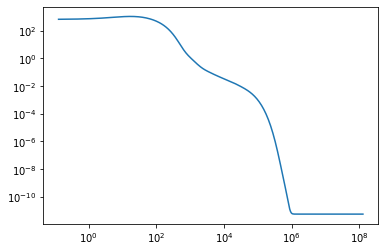

In [22]:
# index_sel = which states in data file are part of largest connected component and hence are included in KTN

# only states where index_sel = True feature in K,D,B etc. i.e. N = index_sel.sum()

# B: braching prob, K = rates, D = total rate per state, u = energy, s = entropy, Emin = min E, 

data_path = "KTN_data/LJ38/4k/"

B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s
BF -= BF.min()

# AB regions
AS,BS = kio.load_AB(data_path,index_sel)


# select states not in A,B AND not in the lowest 10% free energy of states not in A,B
rm_reg = np.zeros(N,bool)
rm_reg[~(AS+BS)] = BF[~(AS+BS)]>np.percentile(BF[~(AS+BS)],10.0)

# retained states are selected by the NOT of this vector, i.e. ~rm_reg

# negative reduced rate matrix (i.e. K-D)
GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]


# Reduced Boltzmann in A
rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()

# select states in B
RBS = BS[~rm_reg]


Q = GT_Q[:,~RBS][~RBS,:] # block NOT in B - this is an absorbing matrix which we diagonalize to get pdf etc

# first moment = 1.Q^{-1}.rho = 1.x
x = spsolve(Q,rho[~RBS])
tau = x.sum()

# Second moment = 2 x 1.Q^{-2}.rho = 2.0* 1.Q^{-1}.x
y = spsolve(Q,x)
tau_sq =  2.0*y.sum()


# pdf
pt = np.zeros((2,400))
pt[0] = np.logspace(-6,3,pt.shape[1])*tau
nu,v,w = spla.eig(Q.todense(),left=True)
dp = np.sqrt(np.diagonal(w.T.dot(v))).real
v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
nu = nu.real
pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()


plt.loglog(pt[0],pt[1])




# Function to do same thing at many temperatures, loading in each time

In [23]:


def loadin(beta,dopdf=False):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0))
    BF = beta*u-s
    BF -= BF.min()
    
    
    
    AS,BS = kio.load_AB(data_path,index_sel)
    
    rm_reg = np.zeros(N,bool)
    rm_reg[~(AS+BS)] = BF[~(AS+BS)]>np.percentile(BF[~(AS+BS)],10.0)
    
    r_BF = BF[~rm_reg]
    
    print(rm_reg.sum(),(~(AS+BS)).sum())
    
    #rm_reg = ~(AS+BS)
    
    
    if dopdf:
        # taur p pgt
        pt = np.zeros((6,400))
    
    D = np.ravel(K.sum(axis=0))
    
    rho = np.exp(-BF) * AS
    rho /= rho.sum()
    tau = np.zeros(4)
    Q = (diags(D)-K)[~BS,:][:,~BS]
    x = spsolve(Q,rho[~BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
    
    
    
    
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    
    Q = (diags(D)-K)[~AS,:][:,~AS]
    x = spsolve(Q,rho[~AS])
    y = spsolve(Q,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    
    if dopdf:
        pt[3] = np.logspace(-6,3,pt.shape[1])*tau[2]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[4] = (v*w*nu)@np.exp(-np.outer(nu,pt[3]))*(v*w/nu).sum()
        
    
    
    # standard GT
    gttau = np.zeros(4)
    rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
    GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
    RBS = BS[~rm_reg]
    Q = GT_Q[:,~RBS][~RBS,:]
    x = spsolve(Q,rho[~RBS])
    y = spsolve(Q,x)
    gttau[0] = x.sum()
    gttau[1] = 2.0*y.sum()
    
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
    
    rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
    RAS = AS[~rm_reg]
    
    Q = GT_Q[:,~RAS][~RAS,:]
    x = spsolve(Q,rho[~RAS])
    y = spsolve(Q,x)
    gttau[2] = x.sum()
    gttau[3] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RAS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[5] = (v*w*nu)@np.exp(-np.outer(nu,pt[3])) * (v*w/nu).sum()
    
    if dopdf:
        return beta,tau,gttau,pt
    else:
        return beta,tau,gttau

In [8]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    
    data[i][0],data[i][1:5],data[i][5:9] = loadin(_beta)
    print(data[i][5]/data[i][1])

N,N_TS: 4000 2653
690 767
1.0000000000000213
N,N_TS: 4000 2653
690 767
1.0000000000000109
N,N_TS: 4000 2653
690 767
1.0000000000000082
N,N_TS: 4000 2653
690 767
1.0
N,N_TS: 4000 2653
690 767
1.0000000000000004
N,N_TS: 4000 2653
690 767
1.0
N,N_TS: 4000 2653
690 767
1.0
N,N_TS: 4000 2653
690 767
0.9999999999999989
N,N_TS: 4000 2653
690 767
1.0000000000000022
N,N_TS: 4000 2653
690 767
0.999999999999986
N,N_TS: 4000 2653
690 767
1.0000000000000022
N,N_TS: 4000 2653
690 767
0.9999999999999906
N,N_TS: 4000 2653
690 767
0.9999999999999901
N,N_TS: 4000 2653
690 767
1.0000000000001255
N,N_TS: 4000 2653
690 767
1.0000000000000704
N,N_TS: 4000 2653
690 767
0.9999999999997173
N,N_TS: 4000 2653
690 767
0.9999999999997116
N,N_TS: 4000 2653
690 767
1.0000000000007023
N,N_TS: 4000 2653
690 767
0.9999999999991741
N,N_TS: 4000 2653
690 767
0.999999999999562


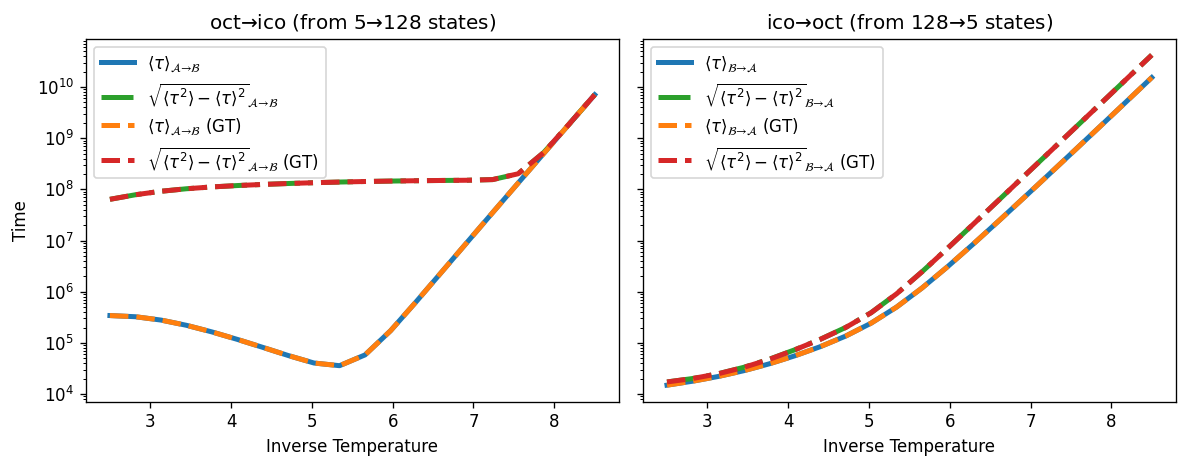

In [9]:

fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)



for j in range(2):
    
    names=['oct','ico']
    size=[5,128]
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
    names=['A','B']
    ax[j].plot(data[:,0],data[:,1+2*j],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,2+2*j]-data[:,1+2*j]**2),'C2-.',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    
    ax[j].plot(data[:,0],data[:,5+2*j],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,6+2*j]-data[:,5+2*j]**2),'C3--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))

    #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    ax[j].set_xlabel("Inverse Temperature")
    if j==0:
        ax[j].set_ylabel("Time")
    ax[j].legend()
    ax[j].set_yscale("log")
plt.tight_layout()
plt.savefig("GT_retain_r10.pdf")

In [14]:
_beta = 1.0/0.25
beta,tau,gttau,pt = loadin(_beta,dopdf=True)


N,N_TS: 4000 2653
690 767


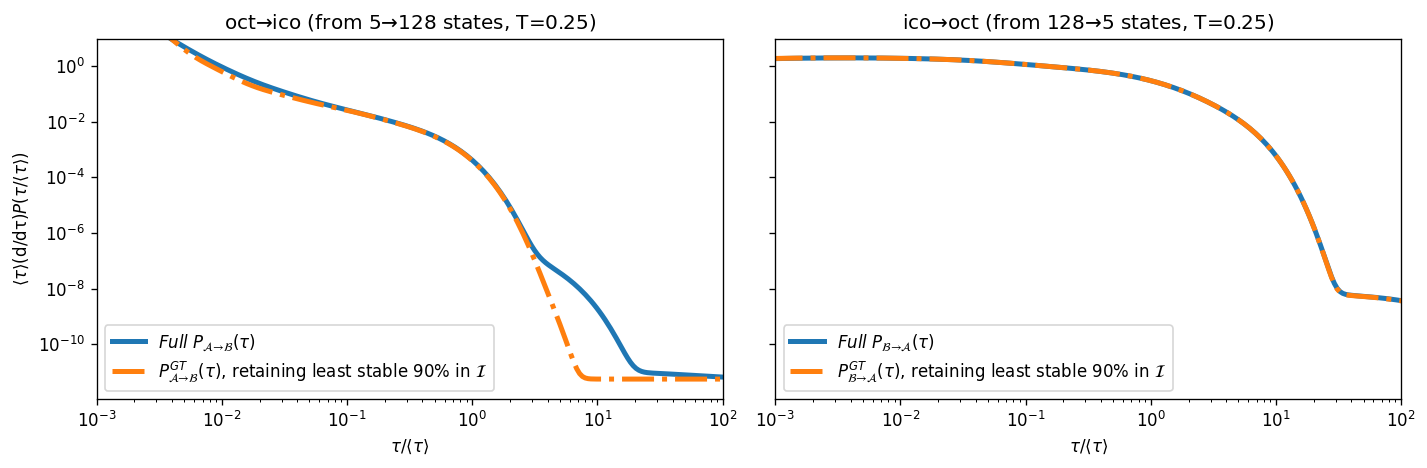

In [15]:

size=[5,128]

fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=120,sharey='row')#,sharex='col')
for j in range(2):
    names=['oct','ico']
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states, T=%2.2g)" % (names[j],names[1-j],size[j],size[1-j],1.0/_beta))
    names=["A","B"]

    ax[j].plot(pt[3*j]/tau[2*j],pt[1+3*j],'C0-',lw=3,label=r"$Full$ $P_\mathcal{%s\to{%s}}(\tau)$" % (names[j],names[1-j]))
    ax[j].plot(pt[3*j]/tau[2*j],pt[2+3*j],'C1-.',lw=3,label=r"$P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining least stable 90%% in $\mathcal{I}$" % (names[j],names[1-j]))
    #ax[j].plot(pt[3*j]/tau[2*j],npt[2+3*j],'C2-.',lw=3,label=r"$ P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining most stable 10%% in $\mathcal{I}$" % (names[j],names[1-j]))
    
    ax[j].legend()
    ax[j].set_yscale("log")
    ax[j].set_xscale("log")
    ax[j].set_xlim(0.001,100.)
    ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
    if j==0:
        ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
    ax[j].set_ylim(pt[1+3*j].min()/10.0,10.0)
plt.tight_layout()
plt.savefig("GT_WT_025.pdf")